# Barlow's equation in conjungtion with the KAPA methods.

The Barlow's equation is used for the compute the internal yield pressure in a tubular-thinned wall cylinder. 

In [31]:
#Importing some modules that will be used later
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt
%matplotlib inline

## Barlow as a thick wall hoop stress

Barlow's equation:
$$ p_b = 2\frac{\sigma_y t}{D_0}$$
The previuos expression is widely used to compute the burst pressure. This formula estimate the internal pressure that the pipe withstand given its geometry ($t/D$) and material strength ($\sigma_y$).

In [32]:
def barlow_pressure(sigma ,thickness ,diameter):
    return 2.* sigma * thickness / diameter

### Case of study

For the sake of have a better understanding, lets consider the following crack profile on a 30" diameter pipe with a wall thickness of 0.375". Also, for the pipe let us consider a SMYS of 60100 psi and a design factor of 0.72 for a maximum operating pressure (MOP) of 1503 psi. For this case, we'are going to assume a upper Charpy V-notch (CVN) of 25 ft-lb. 

In [33]:
# thickness and diameter are expressed on inches. sigma is expressed in psi.
thickness = 0.375
diameter = 30
sigma = 60100
#sigma = 78518
MOP = 1503
design_factor = 0.72

# Importing some crack profile
cprof = pd.read_excel('test_case.xlsx')

# Computing the SMYS pressure for the following profile
smys_pressure = np.zeros(len(cprof))
for i, i_row in cprof.iterrows():
    smys_pressure[i] = barlow_pressure(sigma, thickness - cprof['depth'][i], diameter)

cprof['smys_pressre'] = smys_pressure


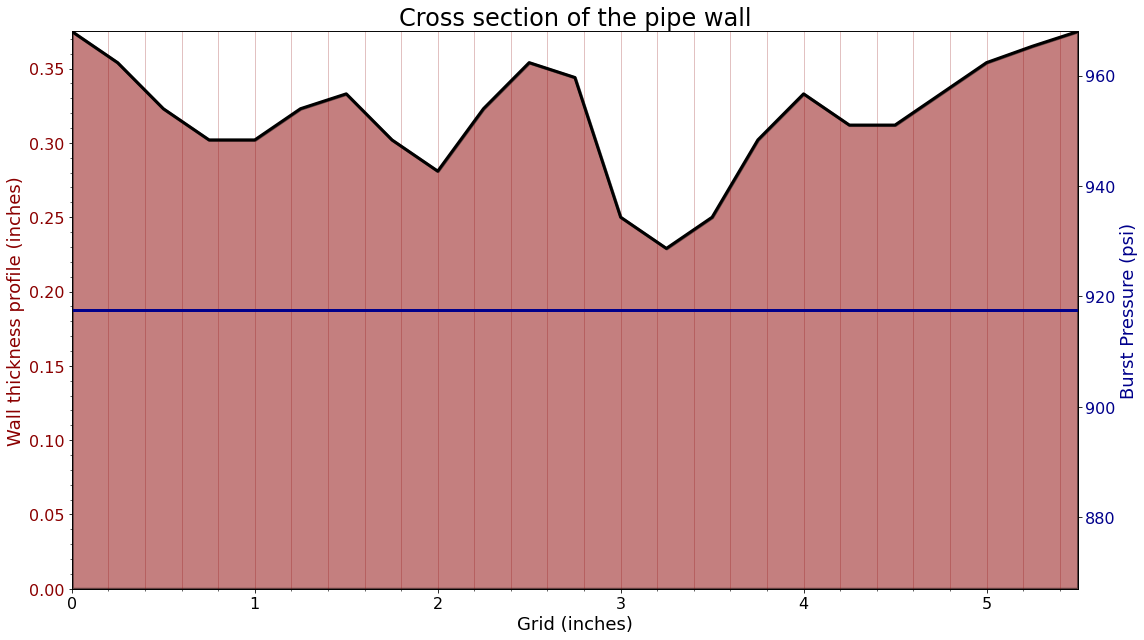

In [34]:
# Plotting the crack profile

x_axis = cprof['profile_spacing'].to_numpy()

color1 = 'darkred'
color2 = 'darkblue'

fig, axs = plt.subplots(figsize=(16,9))

axs.fill_between(cprof['profile_spacing'], thickness - cprof['depth'], 0, linewidth=3, color=color1, alpha=0.5, ec='black')
axs.plot(cprof['profile_spacing'], thickness - cprof['depth'], linewidth=3, color='black')

axs.set_xlabel('Grid (inches)', size=18)
axs.tick_params(axis='x', labelsize=16)

axs.set_ylabel('Wall thickness profile (inches)', size=18, color=color1)
axs.tick_params(axis='y', labelcolor=color1, labelsize=16)

axs.set_xlim(min(cprof['profile_spacing']), max(cprof['profile_spacing']))
axs.set_ylim(0, thickness)

axs.minorticks_on()
axs.grid(axis='x', which='both', color=color1, alpha=0.3)

axs1 = axs.twinx()
axs1.hlines(cprof['smys_pressre'].min(), x_axis[0], x_axis[-1], linewidth=3, color=color2)

axs1.set_ylabel('Burst Pressure (psi)', size=18, color=color2)
axs1.tick_params(axis='y', labelcolor=color2, labelsize=16)

plt.title('Cross section of the pipe wall', size=24)
fig.tight_layout()

## KAPA for a crack-like defect.

The failure stress (in psi) computed through the KAPA method, is given by the following equation:

$$ 3\dfrac{\pi \epsilon (C_v/A_v)}{{\bar\sigma}^2L} = \ln\left[\sec\left( \dfrac{\pi}{2}\dfrac{M_p\sigma_p}{\bar\sigma}\right) \right] $$

Where $C_v$ is the upper shelf Charpy V-notch impact energy (ft-lb) and $A_v$ is the area expressed in square inches. $\epsilon$ is the elastic modulus (psi). $\bar \sigma$ flow stress (SMYS + 10 000 psi) (psi) and $\sigma_p$ is the failure stress (psi). With $M_p$ is given by

$$ M_p = \dfrac{1-\frac{A}{A_0}M_T^{-1}}{1-\frac{A}{A_0}} $$ 

$M_T$ si given by:

$$ M_T = \begin{cases} 
\sqrt{1 + 0.62756 \frac{L^2}{Dt} - 0.003375 \left(\frac{L^2}{Dt}\right)^2} & \text{if} &L \leq \sqrt{50 Dt} \\ 
0.032 \frac{L^2}{Dt} + 3.3 & \text{if} &L>\sqrt{50 Dt} 
\end{cases} $$

In order to compute the burst stress, the first step is to compute the whole area of the missing region (shadowed on blue). For that purpose we use the following formula for each segment $$ A = \sum_{i} \dfrac{\Delta x_i \times (y_{i+1} + y_i)}{2} $$

In [35]:
# Lost area...
def lost_area(x, y):
    '''Compute the area of the lost profile using a trapezoid formula 
    Input: x, y which are the data points
    Output the overall area
    '''
    area = 0.0

    if len(x) == len(y):
        n_size = len(x)
        for i in range(n_size-1):
            h = x[i+1] - x[i]
            area += 0.5 * h * (y[i+1]+y[i])
        return area
    else:
        print('x and y are not of the same saize. Size(x): {}, size(y){}'.format(len(x), len(y)))
        pass

Text(13    2.75
Name: profile_spacing, dtype: float64, 13    0.179
Name: depth, dtype: float64, 'The missing area (blue colored) on the wall thickness profile is: 0.323 square inches')

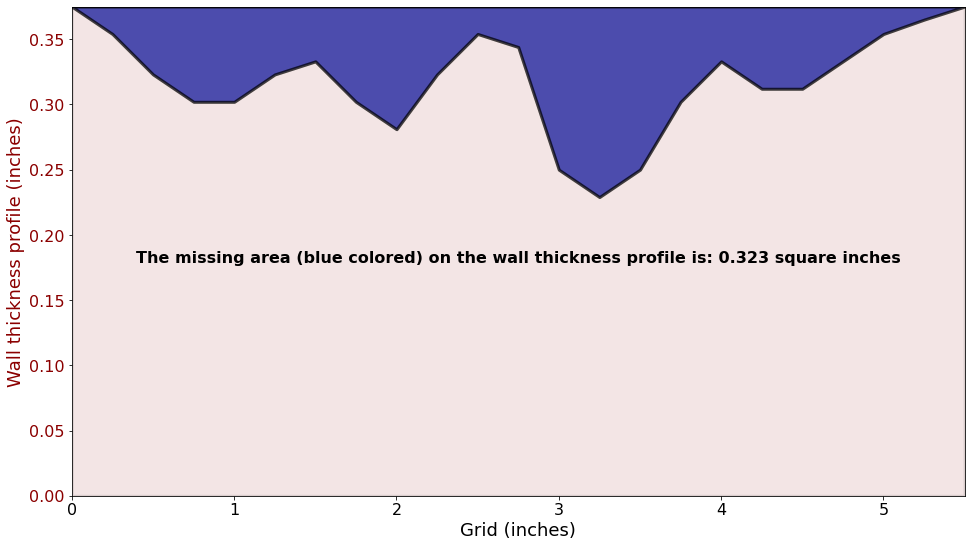

In [36]:
# Compute the lost area on the wall
x = cprof['profile_spacing'].to_numpy()
y = cprof['depth'].to_numpy()

area = lost_area(x, y)

color1 = 'darkred'
color2 = 'darkblue'

fig, axs = plt.subplots(figsize=(16,9))

axs.fill_between(cprof['profile_spacing'], thickness - cprof['depth'], 0, linewidth=3, color=color1, alpha=0.1, ec='black')
axs.fill_between(cprof['profile_spacing'], thickness - cprof['depth'], thickness, linewidth=3, color=color2, alpha=0.7, ec='black')

axs.set_xlabel('Grid (inches)', size=18)
axs.tick_params(axis='x', labelsize=16)

axs.set_ylabel('Wall thickness profile (inches)', size=18, color=color1)
axs.tick_params(axis='y', labelcolor=color1, labelsize=16)

axs.set_xlim(min(cprof['profile_spacing']), max(cprof['profile_spacing']))
axs.set_ylim(0, thickness)

g_comment = 'The missing area (blue colored) on the wall thickness profile is: {:.3f} square inches'.format(area)
arrow_end = cprof[cprof['depth'] == cprof['depth'].max()]

x_arrow = arrow_end['profile_spacing']
y_arrow = thickness-arrow_end['depth']

axs.text(x_arrow-0.5, y_arrow-0.05, g_comment,  fontsize=16, horizontalalignment='center', fontweight='bold')

The Folias factor (MT) is a term that describes the ***bulging*** effect of a shell surface that is thinner in wall thickness than the surrounding shell. This phenomenon exists for internal pressure and is more pronounced for smaller diameter shells. The Folias factor is a function of the flaw length divided by the shell's diameter and thickness. As the shell diameter increases, the Folias factor approaches 1.0. Thus, the parameter generally is more important to piping than vessels. It was first analytically derived by Efthymios S. Folias in 1964.

This factor was determined by Kiefner and Veith and it is given by:
$$ M_T = \begin{cases} 
\sqrt{1 + 0.62756 \frac{L^2}{Dt} - 0.003375 \left(\frac{L^2}{Dt}\right)^2} & \text{if} &L \leq \sqrt{50 Dt} \\ 
0.032 \frac{L^2}{Dt} + 3.3 & \text{if} &L>\sqrt{50 Dt} 
\end{cases} $$

In [37]:
# Folias factor function...
def folias_factor(L, D, t):
    ''' Folias factor is computed using the total lenght of the crack (L), the nominal diameter (D), and the pipe wall thickness (t)'''
    x = L**2/(D*t)

    if np.sqrt(50 * D*t) <= L:
        return np.sqrt(1 + 0.62756 * x - 0.003375 * x**2)
    else:
        return 0.032 * x + 3.3    


def M_P(area, area_O, Folias_Factor):
    return (1-(area/area_0)*np.power(Folias_Factor, -1.))/(1-(area/area_0))

The failure stress (in psi) computed through the KAPA method, is given by the following equation:

$$ \sigma_p = \dfrac{2 \bar \sigma}{\pi M_p} \sec^{-1} \left[ \exp \left( \dfrac{3\pi\epsilon[C_v/A_v]}{\bar\sigma^2L} \right) \right] $$

In [38]:
# Defining the arcsec function.
def asec(x):
    if x == 0:
        return 1j * math.inf
    else:
        return math.acos(1 / x)

In [39]:
# Computing the sigma_p function.... All units are expressed on inches and psi
def sigma_p(sigma_SMYS, epsilon, L, M_P, C_v=25., A_v=0.1550004774):
    bar_sigma = sigma_SMYS + 10000 
    A = (2 * bar_sigma)/(np.pi / M_P)
    rr = C_v/A_v
    EE = (3 * np.pi * rr * epsilon) / (L * bar_sigma**2)
    return  A * asec(math.exp(EE))


For the current example in which the pipe diameter is D=30", the nominal wall thickness t=0.375", the $\sigma_{SMYS}$ = 60 100 psi

In [40]:
L = x_axis[-1] - x_axis[0]
area_0 = L * thickness
epsilon = 29000000

Folias_Factor = folias_factor(L, diameter, thickness)
MP = M_P(area, area_0, Folias_Factor)

sigma_P = sigma_p(sigma, epsilon, L, MP)
burst_pressure = barlow_pressure(sigma_P ,thickness ,diameter)

print('The stress considering the crack is {:.1f} psi and the burst pressure is {:.1f} psi'. format(sigma_P, burst_pressure))
print('Safety factor is: {:.2f} and the Maximum Allowable Pressure (MAP) is {:.1f} psi'. format(burst_pressure/MOP, MOP*design_factor))

The stress considering the crack is 69345.8 psi and the burst pressure is 1733.6 psi
Safety factor is: 1.15 and the Maximum Allowable Pressure (MAP) is 1082.2 psi
